In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms

In [2]:
TIC = 'TIC 181949561' #WASP-39b / TIC 181949561

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))

lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 181949561" SECTOR=51 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [3]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2692.9591837111434,1.0026319e+00,2.5027478e-03,5.7287840e-03,1055159,618.38498,866.25181,4.0393496e+03,1.0060067e+01,2.7287864e+03,4.5851231e+00,4.6408438e+03,1.1584373e+01,0,———,———,———,———,618.38498,1.9717452e-03,866.25181,1.9793832e-03,-5.8685638e-02,8.0632448e-02
2692.9605726003288,1.0003240e+00,2.5057544e-03,5.7287849e-03,1055160,618.37992,866.24697,4.0317229e+03,1.0072153e+01,2.7424441e+03,4.5912933e+00,4.6301611e+03,1.1598289e+01,0,———,———,———,———,618.37992,1.9755657e-03,866.24697,1.9882147e-03,-5.8915585e-02,7.4570499e-02
2692.961961489049,1.0007342e+00,2.5062345e-03,5.7287854e-03,1055161,618.38252,866.25050,4.0331528e+03,1.0074082e+01,2.7415742e+03,4.5966668e+00,4.6320601e+03,1.1600512e+01,0,———,———,———,———,618.38252,1.9735647e-03,866.25050,1.9861213e-03,-5.7727616e-02,7.9196885e-02
2692.963350378234,1.0020903e+00,2.5092242e-03,5.7287863e-03,1055162,618.38306,866.25022,4.0376621e+03,1.0086101e+01,2.7576370e+03,4.6068540e+00,4.6383369e+03,1.1614350e+01,0,———,———,———,———,618.38306,1.9762428e-03,866.25022,1.9861609e-03,-6.0848914e-02,8.0616929e-02
2692.9647392669526,9.9770105e-01,2.5077639e-03,5.7287868e-03,1055163,618.38317,866.23965,4.0219282e+03,1.0080231e+01,2.7603035e+03,4.6031342e+00,4.6180205e+03,1.1607591e+01,0,———,———,———,———,618.38317,1.9806640e-03,866.23965,1.9930343e-03,-5.6578293e-02,6.6806413e-02
2692.966128155673,9.9928004e-01,2.5095625e-03,5.7287873e-03,1055164,618.38177,866.24794,4.0263508e+03,1.0087461e+01,2.7621360e+03,4.6097593e+00,4.6253291e+03,1.1615915e+01,0,———,———,———,———,618.38177,1.9833539e-03,866.24794,1.9938273e-03,-5.6851361e-02,8.0369838e-02
2692.967517044858,1.0025119e+00,2.5126385e-03,5.7287882e-03,1055165,618.38355,866.24473,4.0399487e+03,1.0099825e+01,2.7700913e+03,4.6116090e+00,4.6402881e+03,1.1630154e+01,0,———,———,———,———,618.38355,1.9784779e-03,866.24473,1.9910871e-03,-5.9547819e-02,7.5338073e-02
2692.9689059335783,1.0024220e+00,2.5153474e-03,5.7287887e-03,1055166,618.37949,866.25323,4.0393611e+03,1.0110714e+01,2.7775029e+03,4.6197209e+00,4.6398721e+03,1.1642693e+01,0,———,———,———,———,618.37949,1.9808933e-03,866.25323,1.9902526e-03,-6.2744863e-02,8.5587136e-02


In [4]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.sap_flux)
yerrs = np.array(lc.sap_flux_err)

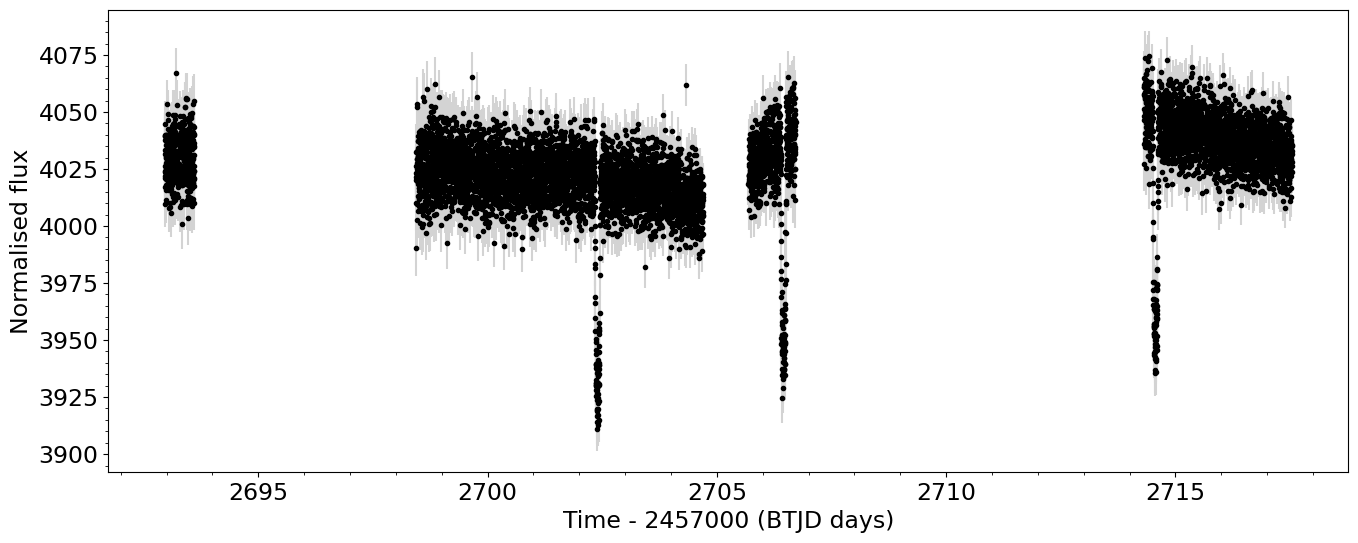

In [5]:
fig, ax = plt.subplots(1, figsize=(16,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [7]:
search_result = lk.search_targetpixelfile(
    target=TIC,
    mission='TESS', author='SPOC')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,SPOC,120,181949561,0.0


In [10]:
tpf = search_result.download()
first_cadence = tpf[0]

<AxesSubplot:title={'center':'Target ID: 181949561, Cadence: 1055155'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

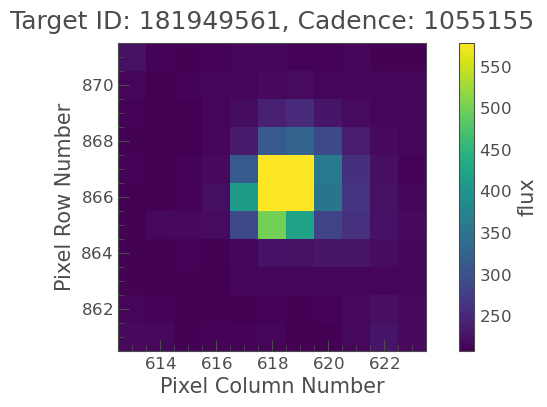

In [11]:
first_cadence.plot(column='flux')

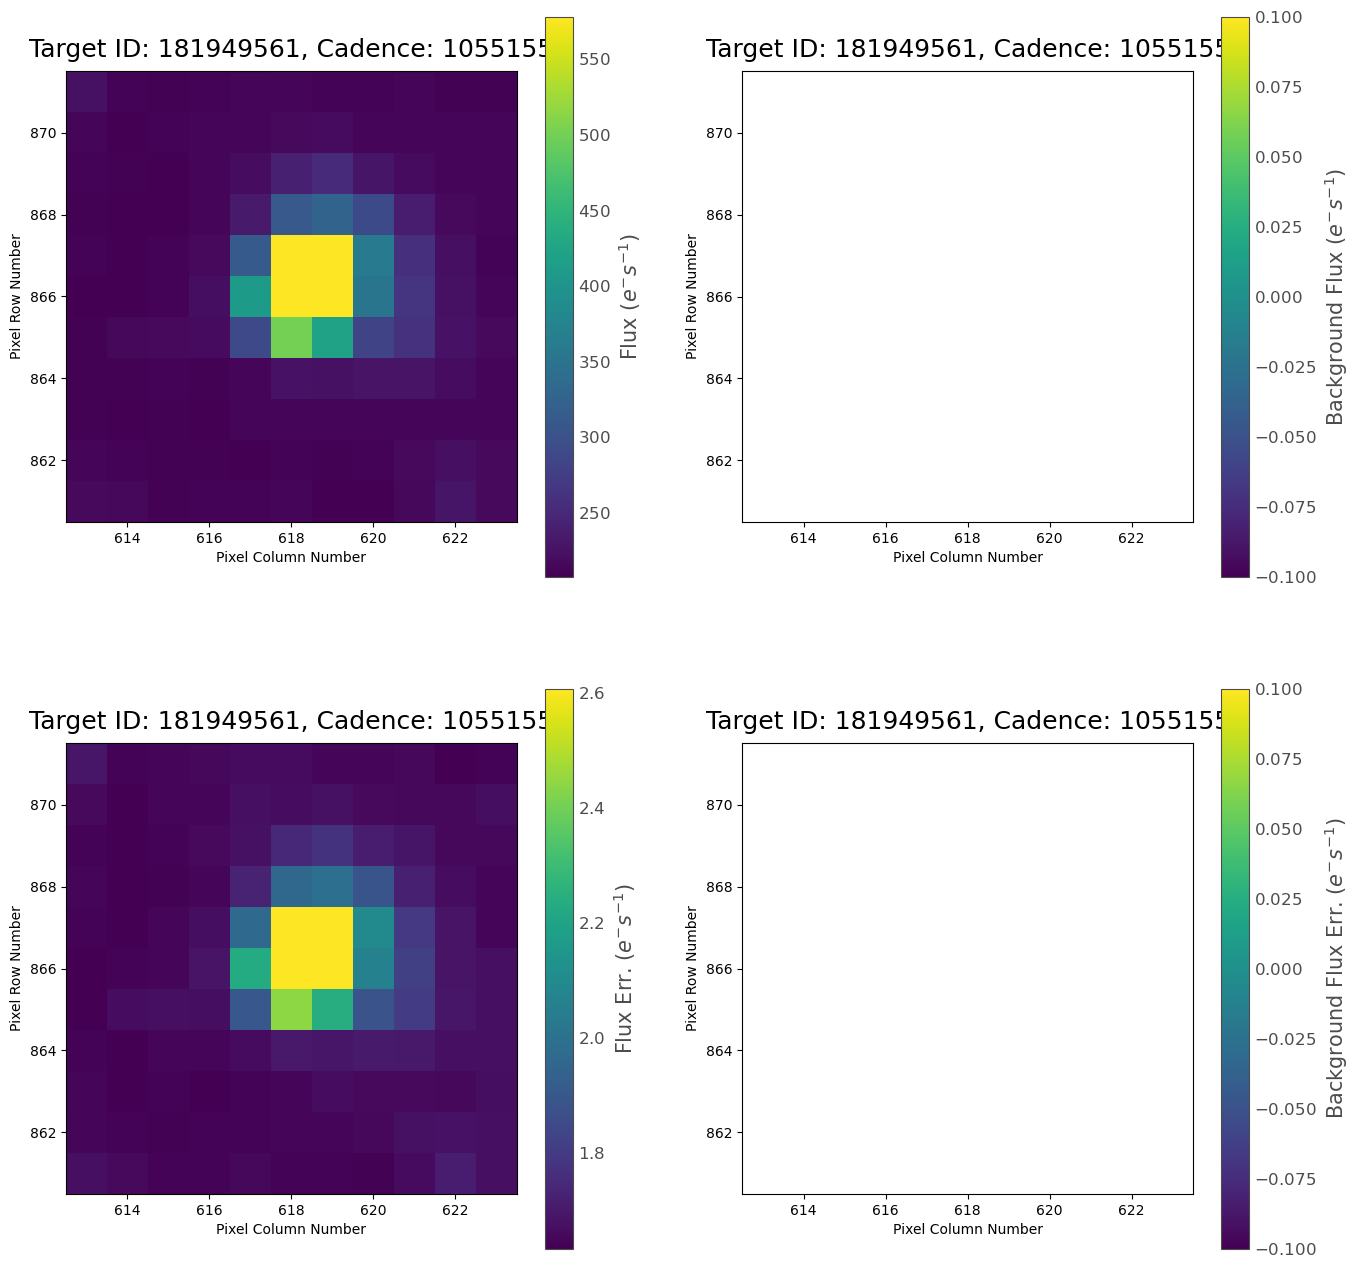

In [12]:
fig, axes = plt.subplots(2,2, figsize=(16,16))
first_cadence.plot(ax=axes[0,0], column='FLUX')
first_cadence.plot(ax=axes[0,1], column='FLUX_BKG')
first_cadence.plot(ax=axes[1,0], column='FLUX_ERR')
first_cadence.plot(ax=axes[1,1], column='FLUX_BKG_ERR')